# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

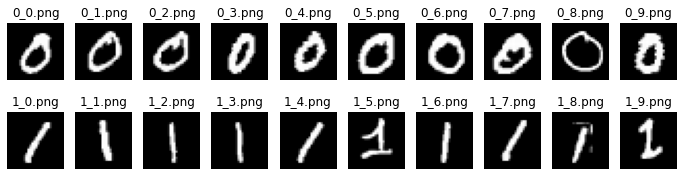

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

In [3]:
from skimage.morphology import erosion, disk
from skimage.segmentation import mark_boundaries, clear_border
from skimage.measure import label, regionprops
import numpy as np
import cv2 as cv
from scipy.interpolate import splprep, splev

In [4]:
def resampling_cnt(cnt):
    x,y = cnt.T
    x = x.tolist()[0]
    y = y.tolist()[0]

    tck, u = splprep([x,y],k=5, s=0)
    
    u_sampled = np.linspace(u.min(), u.max(), 100)
    
    x_sampled, y_sampled = splev(u_sampled, tck, der=0)

    sampled_points = [[[int(i[0]), int(i[1])]] for i in zip(x_sampled,y_sampled)]
    
    return np.asarray(sampled_points, dtype=np.int32)

In [5]:
def compute_descriptors(img):
    descriptors_select =[]
    
    for im in range(0, len(img)):
        im_binary = cv.inRange(img[im], (190), (255))

        contours = cv.findContours(im_binary, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[-2]
        
        contours_big = []
        for cnt in contours:
            if np.size(cnt)>10:
                contours_big.append(cnt)
                              
        full_cnt = np.vstack(contours_big)

        sampled_cnt = resampling_cnt(full_cnt)
           
        contour_complex = [complex(sampled_cnt[i][0][0], sampled_cnt[i][0][1]) for i in range(0, len(sampled_cnt))]
        descriptors = np.fft.fft(contour_complex)
        #don't use a0 so that it is translation invariant
        #norm so that it is rotation invariant
        #ratio so that it is scaling invariant
        a1 = np.sqrt((descriptors[1].real)**2 + (descriptors[1].imag)**2)
        a2 = np.sqrt((descriptors[2].real)**2 + (descriptors[2].imag)**2)
        a3 = np.sqrt((descriptors[3].real)**2 + (descriptors[3].imag)**2)
        descriptors_select.append((a2/a1, a3/a1))

    
    return descriptors_select

In [6]:
descriptors_zeros = compute_descriptors(zeros_im)
descriptors_ones = compute_descriptors(ones_im)

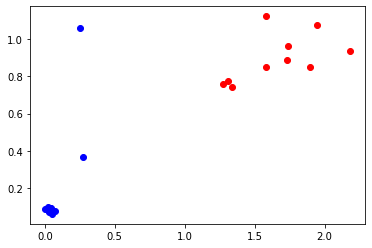

In [7]:
a1_zeros = [a[0] for a in descriptors_zeros]
a2_zeros = [a[1] for a in descriptors_zeros]
a1_ones = [a[0] for a in descriptors_ones]
a2_ones = [a[1] for a in descriptors_ones]
plt.scatter(a1_zeros, a2_zeros, color='r')
plt.scatter(a1_ones, a2_ones, color='b')
plt.show()

In [8]:
def plot_descriptors(a1_zeros, a2_zeros, a1_ones, a2_ones, title):
    plt.scatter(a1_zeros, a2_zeros, color='r')
    plt.scatter(a1_ones, a2_ones, color='b')
    plt.title(title)
    plt.show()

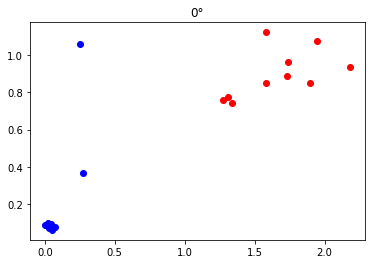

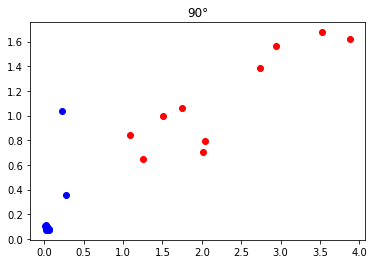

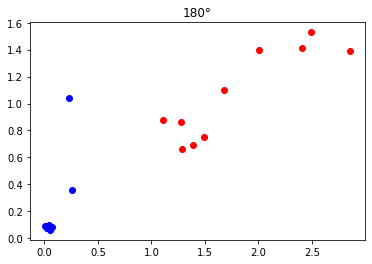

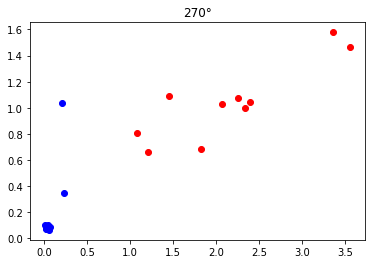

In [9]:
#ROTATION
zeros_im_90 = np.zeros(zeros_im.shape)
zeros_im_180 = np.zeros((zeros_im.shape))
zeros_im_270 = np.zeros((zeros_im.shape))
for im in range(0, len(zeros_im)):
    zeros_im_90[im] = cv.rotate(zeros_im[im], cv.ROTATE_90_CLOCKWISE)
    zeros_im_180[im] = cv.rotate(zeros_im[im], cv.ROTATE_180)
    zeros_im_270[im] = cv.rotate(zeros_im[im], cv.ROTATE_90_COUNTERCLOCKWISE)
    
ones_im_90 = np.zeros(ones_im.shape)
ones_im_180 = np.zeros((ones_im.shape))
ones_im_270 = np.zeros((ones_im.shape))
for im in range(0, len(ones_im)):
    ones_im_90[im] = cv.rotate(ones_im[im], cv.ROTATE_90_CLOCKWISE)
    ones_im_180[im] = cv.rotate(ones_im[im], cv.ROTATE_180)
    ones_im_270[im] = cv.rotate(ones_im[im], cv.ROTATE_90_COUNTERCLOCKWISE)

descriptors_zeros_90 = compute_descriptors(zeros_im_90)
descriptors_zeros_180 = compute_descriptors(zeros_im_180)
descriptors_zeros_270 = compute_descriptors(zeros_im_270)

descriptors_ones_90 = compute_descriptors(ones_im_90)
descriptors_ones_180 = compute_descriptors(ones_im_180)
descriptors_ones_270 = compute_descriptors(ones_im_270)


plot_descriptors([a[0] for a in descriptors_zeros], [a[1] for a in descriptors_zeros], [a[0] for a in descriptors_ones], [a[1] for a in descriptors_ones], '0°')
plot_descriptors([a[0] for a in descriptors_zeros_90], [a[1] for a in descriptors_zeros_90], [a[0] for a in descriptors_ones_90], [a[1] for a in descriptors_ones_90], '90°')
plot_descriptors([a[0] for a in descriptors_zeros_180], [a[1] for a in descriptors_zeros_180], [a[0] for a in descriptors_ones_180], [a[1] for a in descriptors_ones_180], '180°')
plot_descriptors([a[0] for a in descriptors_zeros_270], [a[1] for a in descriptors_zeros_270], [a[0] for a in descriptors_ones_270], [a[1] for a in descriptors_ones_270], '270°')


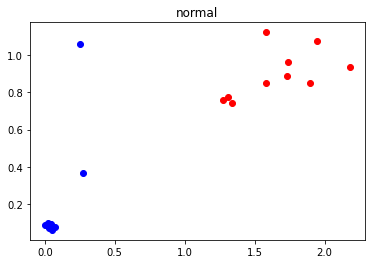

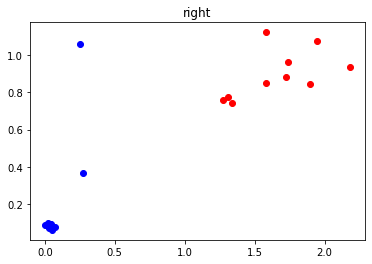

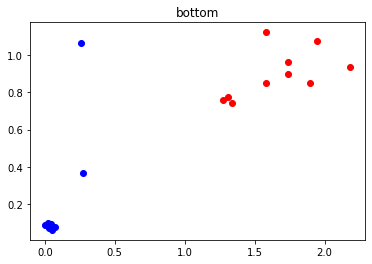

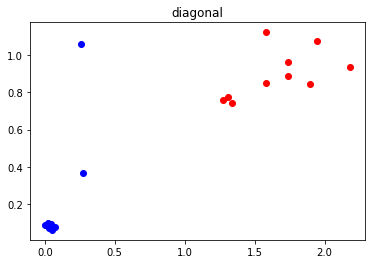

In [10]:
#TRANSLATION

M_right = np.float32([[1, 0, 2],[0, 1, 0]])
M_bot = np.float32([[1, 0, 0],[0, 1, 2]])
M_dia = np.float32([[1, 0, 2],[0, 1, 2]])

zeros_im_right = np.zeros(zeros_im.shape)
zeros_im_bot = np.zeros((zeros_im.shape))
zeros_im_dia = np.zeros((zeros_im.shape))
for im in range(0, len(zeros_im)):
    zeros_im_right[im] = cv.warpAffine(zeros_im[im], M_right, (zeros_im[im].shape[1], zeros_im[im].shape[0]))
    zeros_im_bot[im] = cv.warpAffine(zeros_im[im], M_bot, (zeros_im[im].shape[1], zeros_im[im].shape[0]))
    zeros_im_dia[im] = cv.warpAffine(zeros_im[im], M_dia, (zeros_im[im].shape[1], zeros_im[im].shape[0]))
    
ones_im_right = np.zeros(ones_im.shape)
ones_im_bot = np.zeros((ones_im.shape))
ones_im_dia = np.zeros((ones_im.shape))
for im in range(0, len(ones_im)):
    ones_im_right[im] = cv.warpAffine(ones_im[im], M_right, (ones_im[im].shape[1], ones_im[im].shape[0]))
    ones_im_bot[im] = cv.warpAffine(ones_im[im], M_bot, (ones_im[im].shape[1], ones_im[im].shape[0]))
    ones_im_dia[im] = cv.warpAffine(ones_im[im], M_dia, (ones_im[im].shape[1], ones_im[im].shape[0]))

descriptors_zeros_right = compute_descriptors(zeros_im_right)
descriptors_zeros_bot = compute_descriptors(zeros_im_bot)
descriptors_zeros_dia = compute_descriptors(zeros_im_dia)

descriptors_ones_right = compute_descriptors(ones_im_right)
descriptors_ones_bot = compute_descriptors(ones_im_bot)
descriptors_ones_dia = compute_descriptors(ones_im_dia)


plot_descriptors([a[0] for a in descriptors_zeros], [a[1] for a in descriptors_zeros], [a[0] for a in descriptors_ones], [a[1] for a in descriptors_ones], 'normal')
plot_descriptors([a[0] for a in descriptors_zeros_right], [a[1] for a in descriptors_zeros_right], [a[0] for a in descriptors_ones_right], [a[1] for a in descriptors_ones_right], 'right')
plot_descriptors([a[0] for a in descriptors_zeros_bot], [a[1] for a in descriptors_zeros_bot], [a[0] for a in descriptors_ones_bot], [a[1] for a in descriptors_ones_bot], 'bottom')
plot_descriptors([a[0] for a in descriptors_zeros_dia], [a[1] for a in descriptors_zeros_dia], [a[0] for a in descriptors_ones_dia], [a[1] for a in descriptors_ones_dia], 'diagonal')



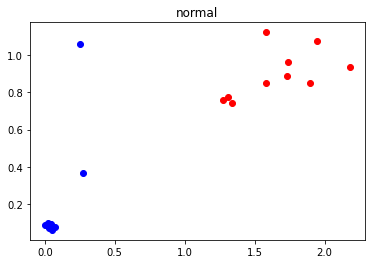

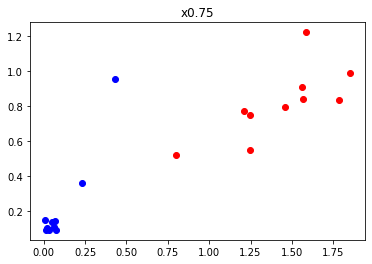

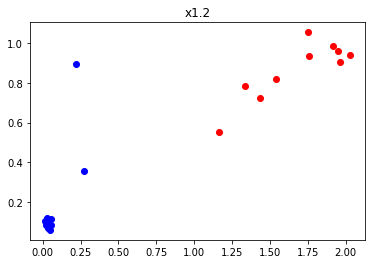

In [11]:
#SCALING
zeros_im_075_prov = np.zeros((10,21,21))
zeros_im_075 = np.zeros((10,28,28))
zeros_im_12_prov = np.zeros((10,34,34))
zeros_im_12 = np.zeros((10,28,28))
for im in range(0, len(zeros_im)):
    zeros_im_075_prov[im] = cv.resize(zeros_im[im], (0,0), fx=0.75, fy=0.75)
    zeros_im_075[im][3:24, 3:24] = zeros_im_075_prov[im]
    zeros_im_12_prov[im] = cv.resize(zeros_im[im], (0,0), fx=1.2, fy=1.2)
    zeros_im_12[im] = zeros_im_12_prov[im][3:31, 3:31]


ones_im_075_prov = np.zeros((10,21,21))
ones_im_075 = np.zeros((10,28,28))
ones_im_12_prov = np.zeros((10,34,34))
ones_im_12 = np.zeros((10,28,28))
for im in range(0, len(ones_im)):
    ones_im_075_prov[im] = cv.resize(ones_im[im], (0,0), fx=0.75, fy=0.75)
    ones_im_075[im][3:24, 3:24] = ones_im_075_prov[im]
    ones_im_12_prov[im] = cv.resize(ones_im[im], (0,0), fx=1.2, fy=1.2)
    ones_im_12[im] = ones_im_12_prov[im][3:31, 3:31]

descriptors_zeros_075 = compute_descriptors(zeros_im_075)
descriptors_zeros_12 = compute_descriptors(zeros_im_12)

descriptors_ones_075 = compute_descriptors(ones_im_075)
descriptors_ones_12 = compute_descriptors(ones_im_12)


plot_descriptors([a[0] for a in descriptors_zeros], [a[1] for a in descriptors_zeros], [a[0] for a in descriptors_ones], [a[1] for a in descriptors_ones], 'normal')
plot_descriptors([a[0] for a in descriptors_zeros_075], [a[1] for a in descriptors_zeros_075], [a[0] for a in descriptors_ones_075], [a[1] for a in descriptors_ones_075], 'x0.75')
plot_descriptors([a[0] for a in descriptors_zeros_12], [a[1] for a in descriptors_zeros_12], [a[0] for a in descriptors_ones_12], [a[1] for a in descriptors_ones_12], 'x1.2')

### 1.3 Additional method (5 pts)

In [12]:
def compute_ad_descriptors(img):
    descriptors_ad =[]
    for im in range(0, len(img)):
        im_binary = cv.inRange(img[im], (1), (255))

        contours = cv.findContours(im_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)[-2]
        max_area_cnt = max(contours, key=cv.contourArea)

        area = cv.contourArea(max_area_cnt)
        perimeter = cv.arcLength(max_area_cnt,True)
        compacity = (perimeter**2)/area

        moment = cv.moments(max_area_cnt)

        descriptors_ad.append((compacity, moment['m00']))
    
    return descriptors_ad

In [13]:
ad_descriptors_zeros = compute_ad_descriptors(zeros_im)
ad_descriptors_ones = compute_ad_descriptors(ones_im)

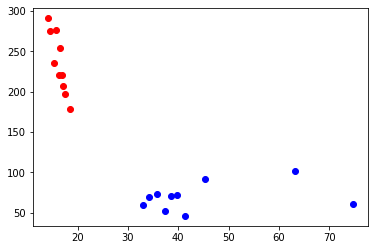

In [14]:
a1_zeros_ad = [a[0] for a in ad_descriptors_zeros]
a2_zeros_ad = [a[1] for a in ad_descriptors_zeros]
a1_ones_ad = [a[0] for a in ad_descriptors_ones]
a2_ones_ad = [a[1] for a in ad_descriptors_ones]
plt.scatter(a1_zeros_ad, a2_zeros_ad, color='r')
plt.scatter(a1_ones_ad, a2_ones_ad, color='b')
plt.show()
    

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

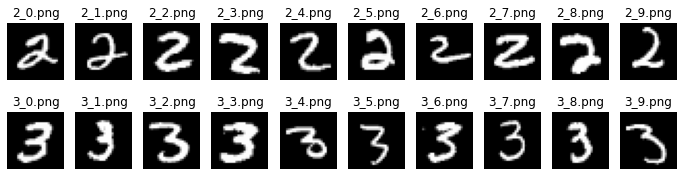

In [15]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [16]:
descriptors_twos = compute_descriptors(twos_im)    
descriptors_threes = compute_descriptors(threes_im)   

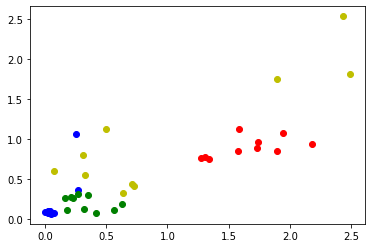

In [17]:
a1_zeros = [a[0] for a in descriptors_zeros]
a2_zeros = [a[1] for a in descriptors_zeros]
a1_ones = [a[0] for a in descriptors_ones]
a2_ones = [a[1] for a in descriptors_ones]
a1_twos = [a[0] for a in descriptors_twos]
a2_twos = [a[1] for a in descriptors_twos]
a1_threes = [a[0] for a in descriptors_threes]
a2_threes = [a[1] for a in descriptors_threes]
plt.scatter(a1_zeros, a2_zeros, color='r')
plt.scatter(a1_ones, a2_ones, color='b')
plt.scatter(a1_twos, a2_twos, color='y')
plt.scatter(a1_threes, a2_threes, color='g')


plt.show()